In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [71]:
import sys
sys.path.append("../code")
import model
from plotting import *
from parametros import alpharange, params
import scipy

In [90]:
# Plot normal distribution for alphas
alphas = ["alpha_R","alpha_w","alpha_u"]

# Normal
means=np.array([params["alpha_R"],params["alpha_u"],params["alpha_w"]])
cov = means/3

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

def get_weights_and_ICU(scenario):
    ICUS = []
    weights = []
    for alpha_R in alpharange:
        for alpha_u in alpharange:
            for alpha_w in alpharange:
                dat = np.load(f"/data.nst/smohr/covid19_wd_sweeps/scen={scenario}-aR={alpha_R}-au={alpha_u}-aw={alpha_w}.npz")["arr_0"]
                weights.append(scipy.stats.multivariate_normal.pdf([alpha_R,alpha_u,alpha_w],mean=means,cov=cov))
                ICUS.append(dat[:,7])
    ICUS = np.array(ICUS)
    weights = np.array(weights)
    return ICUS, weights


def get_bounds(I,w):
    bounds = {}
    bounds["95"] = []
    bounds["75"] = []
    bounds["50"] = []
    for i in range(I.shape[1]):
        bounds["95"].append(weighted_quantile(I[:,i],quantiles=[0.025,0.975],sample_weight=w))
        bounds["75"].append(weighted_quantile(I[:,i],quantiles=[0.50-0.75/2,0.50+0.75/2],sample_weight=w))
        bounds["50"].append(weighted_quantile(I[:,i],quantiles=[0.25,0.75],sample_weight=w))

    for b in bounds:
        bounds[b] = np.array(bounds[b])
        
    return bounds

In [107]:
scenarios = ["scenario1","scenario2","scenario3"]
colors = ["tab:red","tab:orange","tab:green"]
ICUS, weights, bounds, avgs = {},{},{},{}
for s,scenario in enumerate(scenarios):
    # Load data
    ICUS[scenario], weights[scenario] = get_weights_and_ICU(scenario)
    avgs[scenario] = np.average(ICUS[scenario],axis=0,weights=weights[scenario])
    # get bounds to plot ci
    bounds[scenario] = get_bounds(ICUS[scenario],weights[scenario])

In [108]:
# Save file to recreate plot more easily
import pickle
with open("../datamodelruns/sensitivity.pickle","wb") as f:
    pickle.dump((avgs,weights,bounds),f)

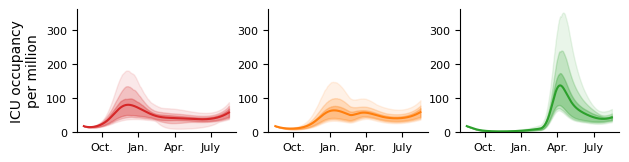

In [104]:
fig, axes = plt.subplots(1,3,figsize=[7,1.6])
for s,scenario in enumerate(scenarios):
    ICU = ICUS[scenario]
    bound = bounds[scenario]
    weight=weights[scenario]
    ax = axes[s]
    # CI plots
    for i,ci in enumerate(["95","75","50"]):
        ax.fill_between(
            times,
            bound[ci][:,0],
            bound[ci][:,1],
            color=colors[s],
            alpha=0.1*i+0.1
        )
    
    # Line
    ax.plot(
        times,
        avgs[scenario],
        color=colors[s]
    )

# Markup
for ax in axes:
    ax.set_ylim(0,360)
    ax.set_xticks([45, 135, 45+2*90, 45+3*90])
    ax.set_xticklabels(['Oct.','Jan.','Apr.','July'])
axes[0].set_ylabel("ICU occupancy\nper million")

"""
# Reference check
dat = np.load(f"/data.nst/smohr/covid19_wd_sweeps/scen=scenario1-aR={0.0073}-au={params['alpha_u']}-aw={0.0182}.npz")["arr_0"]
ax.plot(
    times,
    np.average(ICUS,axis=0,weights=weights),
    color="tab:red"
)
"""
fig.savefig("./figures/sensitivity_icu.pdf",dpi=300,transparent=True,bbox_inches = "tight")
fig.savefig("./figures/sensitivity_icu.png",dpi=300,transparent=True,bbox_inches = "tight")

plt.show()
plt.close(fig=fig)

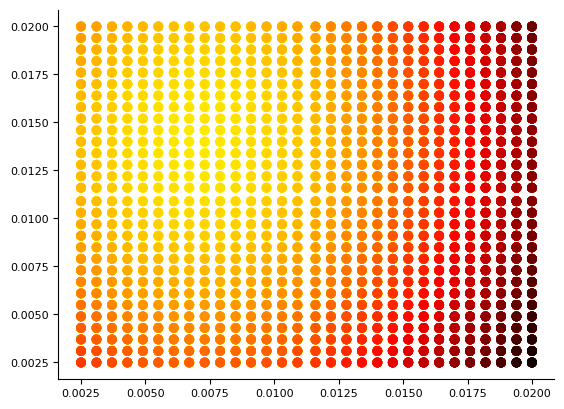

In [118]:
alphas=[]
multi_norm = []
for alpha_R in alpharange:
    for alpha_u in alpharange:
        for alpha_w in alpharange:
            alphas.append([alpha_R,alpha_u,alpha_w])
alphas=np.array(alphas)
plt.scatter(alphas[:,0], alphas[:,1], c = weights["scenario1"], cmap="hot")
plt.show()

In [112]:
weights["scenario1"].shape

(27000,)